In [172]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2
import os
from skimage import measure
import imutils

In [6]:
glareCNN = tf.keras.models.load_model('model/glare/glare_detect.h5')

In [166]:
def drawROIs(image,boxes):
    im = image.copy()
    for box in boxes:
        (startX, startY, endX, endY) = box
        cv2.rectangle(im,(startX, startY),(endX, endY),(255,0,0),2)
    return im

In [101]:
def pred(score):
    pred_class = "" #defining variable to store predictions
    if score[0][0] <0.3: #CNN model refers to 0 as "glare" and 1 as "not glare", applying a threshold for both cases.
        pred_class = "Glare" #values less than 0.5
    else:
        pred_class = "Not Glare" #values greater than 0.5
    return pred_class

In [180]:
def create_mask(image):
    gray = cv2.cvtColor( image, cv2.COLOR_BGR2GRAY )
    blurred = cv2.GaussianBlur( gray, (9,9), 0 )
    _,thresh_img = cv2.threshold( blurred, 230, 255, cv2.THRESH_BINARY)
    thresh_img = cv2.erode( thresh_img, None, iterations=2 )
    thresh_img  = cv2.dilate( thresh_img, None, iterations=4 )
    labels = measure.label( thresh_img, background=0)
    mask = np.zeros( thresh_img.shape, dtype="uint8" )

    for label in np.unique( labels ):
        # if this is the background label, ignore it
        if label == 0:
            continue
        
        labelMask = np.zeros( thresh_img.shape, dtype="uint8" )
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero( labelMask )
        
        if numPixels > 300:
            mask = cv2.add( mask, labelMask )
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = [cv2.boundingRect(c) for c in cnts]
    cnts = [(x,y,x+w,y+h) for (x, y, w, h) in cnts]
    return cnts

In [91]:
def increase_contrast(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl,a,b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

In [108]:
def unblur(image):
    kernel = np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return image

In [168]:
def infer(im):
    image = im.copy()
    glare = False
    (height,width) =image.shape[:2]
    window_size = (int(height*0.1) + int(width*0.1))//2
    #clearimg = unblur(image)
    gray = cv2.cvtColor( image, cv2.COLOR_BGR2GRAY )
    for i in range(1 , height//window_size -1):
        for j in range(1 , width//window_size  -1):
            orig = gray[i * window_size: (i+1) * window_size , j * window_size: (j+1) * window_size ]
            orig = cv2.merge([orig,orig,orig])
            clip = cv2.resize(orig, (64,64), interpolation = cv2.INTER_AREA)
            clip = np.expand_dims(clip, axis = 0) 
            result = glareCNN.predict(clip/255,verbose = 0)
            p = pred(result)
            if p == "Glare":
                glare = True
                cv2.rectangle(image,( j * window_size, i * window_size),((j+1) * window_size, (i+1) * window_size),(255,0,0),2)
    plt.imshow(image)
    plt.title("result")
    plt.show()
    return glare

In [184]:
def rcnn_glare(im,cnts):
    image = im.copy()
    for c in cnts:
        (startX, startY, endX, endY) = c
        clip = image[startY:endY,startX:endX]
        clip = cv2.resize(clip, (64,64), interpolation = cv2.INTER_AREA)
        clip = np.expand_dims(clip, axis = 0) 
        result = glareCNN.predict(clip/255,verbose = 0)
        p = pred(result)
        if p == "Glare":
            cv2.rectangle(image,( startX , startY),(endX ,endY),(255,0,0),2)
    plt.imshow(image)
    plt.title("result")
    plt.show()

Defining the image path and name

In [188]:
img = 'testing.jpg'
image = cv2.imread("../"+img)

Helper function called to run the inference

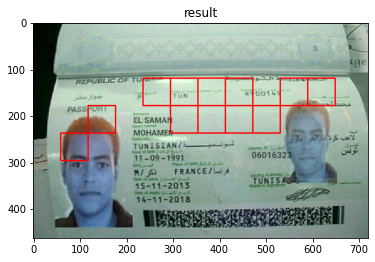

True


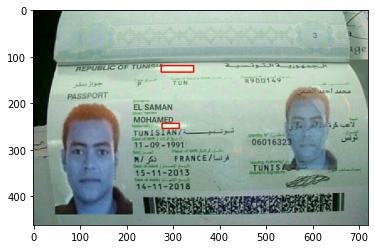

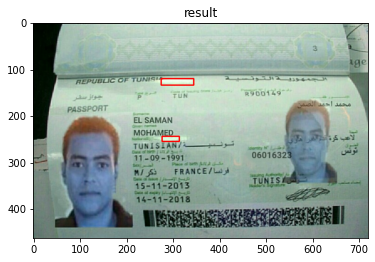

In [189]:
glare = infer(image)
print(glare)
cnts = create_mask(image)
rcnn_glare(image,cnts)

In [ ]:
rcnn_glare()

The image on which the inference was run on

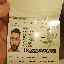

In [9]:
image_calc

In [10]:
print(result, classification)

[[0.98333377]] Not Glare


Now, you can run inferences using the pretrained models via helper functions.  
Another example

In [10]:
img_path = 'images//glare//'
img = 'im2.jpg'

In [11]:
image_calc,result = infer(img_path,img)
classification = pred(result)